# Capsule Network with Dynamic Routing

##References
####Dynamic Routing Between Capsules, Sara Sabour et al.    https://arxiv.org/pdf/1710.09829.pdf
#### Capsule Networks (CapsNets), Aurélien Geron     https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb
####CapsuleNet on MNIST,  Kevin Mader      https://www.kaggle.com/kmader/capsulenet-on-mnist

In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras import backend as K
from keras import Sequential, models, layers

import keras
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer, Input
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
from keras import initializers


%matplotlib inline

Using TensorFlow backend.


#Defining the helper functions

In [0]:
def squash(vector, axis=-1, epsilon=1e-7):
    
    s_squared_norm = K.sum(K.square(vector), axis, keepdims=True)
    safe_norm =  K.sqrt(s_squared_norm + epsilon)
    squash_factor = s_squared_norm / (1.0 + s_squared_norm)
    unit_vector = vector / safe_norm
    
    return squash_factor * unit_vector


In [0]:

class mask(layers.Layer):
    
    def call(self, inputs, **kwargs):
        
        if type(inputs) is list: 
            assert len(inputs) == 2
            inputs, mask = inputs
            
        else:
            x = inputs
            x = (x - K.max(x, axis=1, keepdims=True)) / K.epsilon()+1
            mask = K.clip(x, min_value=0, max_value=1)
            
        return K.batch_dot(inputs, mask, [1,1])
    
    
    def compute_output_shape(self, input_shape):
        
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])
        

In [0]:
class length(layers.Layer):
    
    def call(self, inputs, **kwargs):
        
        x = K.sqrt(K.sum(K.square(inputs), axis = -1))
        
        return x
    
    def compute_output_shape(self, input_shape):
        
        return input_shape[:-1]
    

#Defining the Primary Capsules layers

In [0]:
def primaryCaps(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    '''
    inputs : output of first convolutional layer of shape (?x20x20x256)
    dim_vector : the dimension of the output vector of each capsule = 8
    n_channels : the number of different capsules = 32 
    
    output : output of the convultional layer reshaped to ?x1152x8 and squash function applied to it
    
    '''
    
    conv2 = Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    out = layers.Reshape(target_shape=[-1, dim_vector])(conv2)
    
    return layers.Lambda(squash)(out)


#Defining the Digit Capsules custom layer

In [0]:
class digitCaps(layers.Layer):
    
    def __init__(self, num_capsules, dim_vector, num_routings=3,
                 w_initializer='glorot_uniform', b_initializer='zeros', **kwargs):
        
        super(digitCaps, self).__init__(**kwargs)
        self.num_capsules = num_capsules  #number of capsules in this layer :: 10
        self.dim_vector = dim_vector #dimension of each capsule in this layer :: 16
        self.num_routings = num_routings #number of routing loops 
        self.w_initializer = initializers.get(w_initializer) #initializer for the weights matrix
        self.b_initializer = initializers.get(b_initializer)   #initializer for the bias matrix
        
    def build(self, input_shape):
        
        assert len(input_shape)>=3 
        self.input_num_capsules = input_shape[1]  # 6*6*32 = 1152
        self.input_dim_vector = input_shape[2]  # 8
        
        # initialize the weight matrix and add it to the build
        # can NOT call it weights => overriding 
        self.w = self.add_weight(
            shape=[self.input_num_capsules, self.num_capsules, self.input_dim_vector, self.dim_vector], 
            initializer='glorot_uniform', name='w')
        
        # initialize the bias matrix
        self.bias = self.add_weight(shape=[1, self.input_num_capsules, self.num_capsules, 1, 1], 
                                    initializer=self.b_initializer, trainable=False, name='bias')
        
        self.built = True
        
    def call(self, inputs):
        
        # inputs U of shape ?x1152x8
        # expand U to shape ?x1152x1x1x8
        inputs_expanded = K.expand_dims(K.expand_dims(inputs, 2), 2)
        
        #tile U along axis 2 to become of shape ?x1152x10x1x8
        inputs_tiled = K.tile(inputs_expanded, [1, 1, self.num_capsules, 1, 1])
        
        # compute U*W using tf.scan
        inputs_hat = tf.scan(lambda a, x: K.batch_dot(x, self.w, [3,2]), elems=inputs_tiled, 
                             initializer=K.zeros([self.input_num_capsules, self.num_capsules, 1, self.dim_vector]))
        # u-hat is of shape ?x1152x10x1x16
        
        
        # Routing 
        
        assert self.num_routings>0
        for i in range(self.num_routings):
            c = tf.nn.softmax(self.bias, axis=2)
            out = squash(K.sum(c * inputs_hat, axis=1, keepdims=True))
            
            # since it is not necessary to calculate it for the last iteration to save time and computational power
            if i != self.num_routings - 1:
                self.bias = self.bias + K.sum(inputs_hat*out, axis=-1, keepdims=True)
                
            
        return K.reshape(out, [-1, self.num_capsules, self.dim_vector])
    
    
    def compute_output_shape(self, input_shape):
        
        return tuple([None, self.num_capsules, self.dim_vector])
    

# Building the Capsule network model

In [0]:
def capsNet(input_shape, num_classes, num_routing):
    
    '''
    input_shape : shape of the input to the caps net :: ?x28x28x1
    num_classes : number of output classes = 10
    num_routing : number of iterations for the routing algorithm
    
    returns:
    a keras model with 2 inputs : (images, labels) and 2 outputs: (capsule outputs, reconstructed images)
    '''
    
    #the image input to the model
    x = layers.Input(shape=input_shape)
    
    #first concolutional layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, activation='relu', name='conv1')(x)
    
    # primary capsules layer
    prim = primaryCaps(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    
    # Digit capsules layer
    digi = digitCaps(num_capsules=num_classes, dim_vector=16, num_routings=3)(prim)
    
    #apply length to the output of the digitCaps layer to replace each capsule with its length
    caps_output = length(name='caps_output')(digi)
    
    #Decoder network
    y = layers.Input(shape=(num_classes,))
    
    # use the true label to mask the output
    masked = mask()([digi, y])
    
    x_reconstructed = layers.Dense(512, activation='relu')(masked)
    x_reconstructed = layers.Dense(1024, activation='relu')(x_reconstructed)
    x_reconstructed = layers.Dense(784, activation='sigmoid')(x_reconstructed)
    x_reconstructed = layers.Reshape(target_shape=[28,28,1], name='reconstructed_output')(x_reconstructed)
    
    
    return models.Model([x, y] , [caps_output, x_reconstructed])
    

### Define the model

In [8]:
caps_model = capsNet(input_shape=[28,28,1], num_classes=10, num_routing=3)

caps_model.summary()

W0805 16:53:53.503797 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 16:53:53.521783 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 16:53:53.524269 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1152, 8)      0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
lambda_1 (

# The margin loss
####Defining the margin loss function that will be used to evaluate the output of the encoder portion of the model

In [0]:
def margin_loss(y_true, y_pred):
    
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# Load the mnist dataset

In [10]:
from keras.datasets import mnist

def load_data():
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_test = (x_test.astype(np.float32) - 127.5)/127.5
    
    x_train = x_train.reshape(-1,28,28,1)
    x_test = x_test.reshape(-1,28,28,1)
    
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    
    return (x_train, y_train, x_test, y_test)


(x_train, y_train,x_test, y_test)=load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


#Training the model
####using image augmentation

In [0]:
def train(model, data, batch_size=64 , num_epochs=1, epoch_size_frac=1.0):
    
    '''
    model : the capsnet model
    data : tuple containing ((x_train, y_train) , (x_test, y_test))
    
    returns:
    a trained model
    '''
    # unpack the data 
    (x_train, y_train), (x_test, y_test) = data
    
    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', save_best_only=True, save_weights_only=True,verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))
    
    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'caps_output': 'accuracy'})
    
    # for Training with data augmentation must create a function to give the fit_generator
    def img_gen(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction, height_shift_range=shift_fraction)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
            
    
    # Fit model using fit_generator and the previous image augmentation function as the generator function
    model.fit_generator(generator=img_gen(x_train, y_train, batch_size, 0.1), 
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / batch_size), epochs=num_epochs, 
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    
    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model


In [12]:
train(model=caps_model, data=((x_train, y_train), (x_test[:1000], y_test[:1000])), batch_size=128, 
      num_epochs=15 , epoch_size_frac=0.5)

W0805 16:53:54.288207 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 16:53:54.592029 139867361662848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0805 16:53:55.132201 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0805 16:53:55.281827 139867361662848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign

Epoch 1/15
234/234 [==============================] - 96s 410ms/step - loss: 0.1598 - caps_output_loss: 0.1591 - reconstructed_output_loss: 1.3725 - caps_output_acc: 0.8314 - val_loss: 0.0491 - val_caps_output_loss: 0.0486 - val_reconstructed_output_loss: 0.9294 - val_caps_output_acc: 0.9620

Epoch 00001: val_loss improved from inf to 0.04909, saving model to weights-01.h5
Epoch 2/15
234/234 [==============================] - 91s 390ms/step - loss: 0.0438 - caps_output_loss: 0.0434 - reconstructed_output_loss: 0.8803 - caps_output_acc: 0.9676 - val_loss: 0.0259 - val_caps_output_loss: 0.0255 - val_reconstructed_output_loss: 0.9275 - val_caps_output_acc: 0.9820

Epoch 00002: val_loss improved from 0.04909 to 0.02593, saving model to weights-02.h5
Epoch 3/15
234/234 [==============================] - 92s 392ms/step - loss: 0.0310 - caps_output_loss: 0.0305 - reconstructed_output_loss: 0.8793 - caps_output_acc: 0.9781 - val_loss: 0.0265 - val_caps_output_loss: 0.0261 - val_reconstructed_o

#Testing the CapsNet

In [0]:
def test(model, data):
    
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
    
    generated_images = np.concatenate([x_test[:50],x_recon[:50]])
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

--------------------------------------------------
Test acc: 1.0


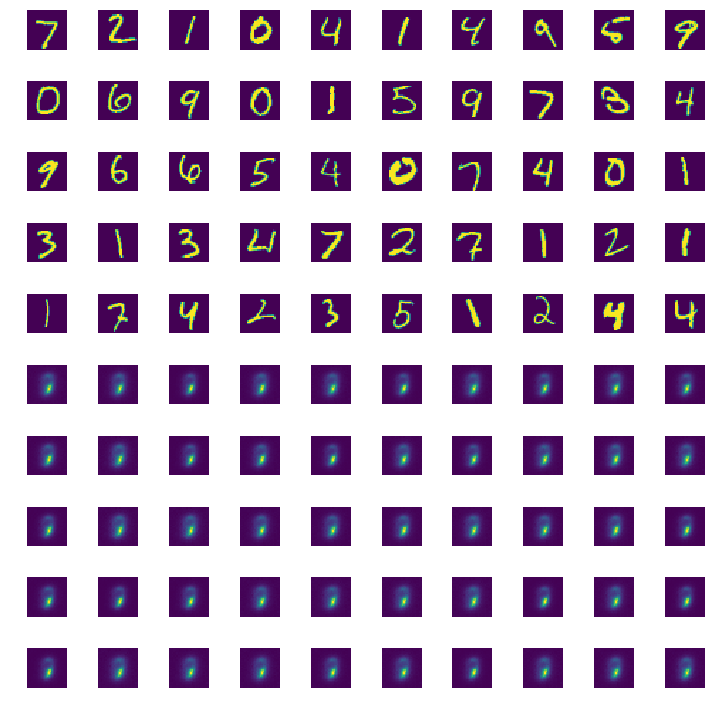

In [16]:
test(model=caps_model, data=(x_test[:100], y_test[:100]))